In [107]:
import seaborn as sns
import numpy as np
import pandas as pd
import plotly.tools as tls
import plotly.offline as py
import plotly.graph_objs as go
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)

from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor
import numpy as np

from matplotlib.pyplot import figure
import findspark
findspark.init("D:\Dataset\Spark\spark-2.3.3-bin-hadoop2.7")
from pyspark import SparkContext
sc = SparkContext()
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, NaiveBayes,\
                                      MultilayerPerceptronClassifier, GBTClassifier
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, \
                            roc_auc_score, roc_curve,precision_score, f1_score


ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=pyspark-shell, master=local[*]) created by __init__ at <ipython-input-1-5e1d3b185871>:15 

Data Information:

1) ID number 2) Diagnosis (M = malignant, B = benign) 3-32)

Ten real-valued features are computed for each cell nucleus:

a) radius (mean of distances from center to points on the perimeter) b) texture (standard deviation of gray-scale values) c) perimeter d) area e) smoothness (local variation in radius lengths) f) compactness (perimeter^2 / area - 1.0) g) concavity (severity of concave portions of the contour) h) concave points (number of concave portions of the contour) i) symmetry j) fractal dimension ("coastline approximation" - 1)

The mean, standard error and "worst" or largest (mean of the three largest values) of these features were computed for each image, resulting in 30 features. For instance, field 3 is Mean Radius, field 13 is Radius SE, field 23 is Worst Radius.

All feature values are recoded with four significant digits.

Missing attribute values: none

Class distribution: 357 benign, 212 malignant

In [108]:
def plot_3d_relation(dataframe,col1,col2,col3):
    '''
    This function plots the 3D scatter plot for a dataframe
    and 3 columns, which it takes up as x, y and z axis
    Parameters:
    dataframe: Name of the dataframe
    col1: x axis
    col2: y axis
    col3: z axis
    '''
    trace1 = go.Scatter3d(
        x=(dataframe[col1]).tolist(),
        y=(dataframe[col2]).tolist(),
        z=(dataframe[col3]).tolist(),
        name = "Malign cancer",
        mode='markers',
        marker=dict(
            color='red',
            size=12,
            symbol='circle',
            line=dict(
                color='white',
                width=1
            ),
            opacity=0.9
        )
    )

    trace2 = go.Scatter3d(
        x=(bc_benign.iloc[:,4]).tolist(),
        y=(bc_benign.iloc[:,8]).tolist(),
        z=(bc_benign.iloc[:,9]).tolist(),
        name = "benign cancer",
        mode='markers',
        marker=dict(
            color='green',
            size=12,
            symbol='circle',
            line=dict(
                color='white',
                width=1
            ),
            opacity=0.9
        )
    )

    data = [trace1,trace2]
    layout = go.Layout(dict(title = "Classification of cancers - Benign or Malign",
                            scene = dict(camera = dict(up=dict(x= 0 , y=0, z=0),
                                                       center=dict(x=0, y=0, z=0),
                                                       eye=dict(x=1.25, y=1.25, z=1.25)),
                                         xaxis  = dict(title = col1,
                                                       gridcolor='rgb(255, 255, 255)',
                                                       zerolinecolor='rgb(255, 255, 255)',
                                                       showbackground=True,
                                                       backgroundcolor='rgb(254,224,144)'),
                                         yaxis  = dict(title = col2,
                                                       gridcolor='rgb(255, 255, 255)',
                                                       zerolinecolor='rgb(255, 255, 255)',
                                                       showbackground=True,
                                                       backgroundcolor='rgb(254,224,144)'
                                                      ),
                                         zaxis  = dict(title = col3,
                                                       gridcolor='rgb(255, 255, 255)',
                                                       zerolinecolor='rgb(255, 255, 255)',
                                                       showbackground=True,
                                                       backgroundcolor='rgb(254,224,144)'
                                                      )
                                        ),
                            height = 900,
                           )
                      )
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig, filename='3d-scatter-colorscale')

## Exploratory Data Analysis

In [109]:
# Reading the dataframe
df = pd.read_csv('data.csv').iloc[:,:-1]

In [110]:
# Viewing the dataset
df.head()

id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

            ...             radius_worst  texture_worst  perimeter_worst  \
0           ...                    25.38          17.33           184.60   
1           ...                    24.99          23.41           158.80   
2           ...                    23.57          25.53           152.50   
3           ...                    14.91          26.50            98.87   
4           ...                    22.54          16.67           152.20   

   area_worst  smoothness_worst  compactness_worst  concavity_worst  \
0      2019.0            0.1622             0.6656           0.7119   
1      1956.0            0.1238             0.1866           0.2416   
2      1709.0            0.1444             0.4245           0.4504   
3       567.7            0.2098             0.8663           0.6869   
4      1575.0            0.1374             0.2050           0.4000   

   concave points_worst  symmetry_worst  fractal_dimension_worst  
0                0.2654          0.4601                  0.11890  
1                0.1860          0.2750                  0.08902  
2                0.2430          0.3613                  0.08758  
3                0.2575          0.6638                  0.17300  
4                0.1625          0.2364                  0.07678  

[5 rows x 32 columns]

In [111]:
# Viewing the columns
df.columns.values[1:]

array(['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean',
       'concavity_mean', 'concave points_mean', 'symmetry_mean',
       'fractal_dimension_mean', 'radius_se', 'texture_se',
       'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se',
       'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'], dtype=object)

In [112]:
data = spark.read.csv('data.csv', header='true', inferSchema='true')
data = data.select([column for column in data.columns if column not in ['_c32', 'id']])
all_features = [x for x in data.columns if x not in ['diagnosis']]

## Outlier Analysis through boxplots

radius_mean


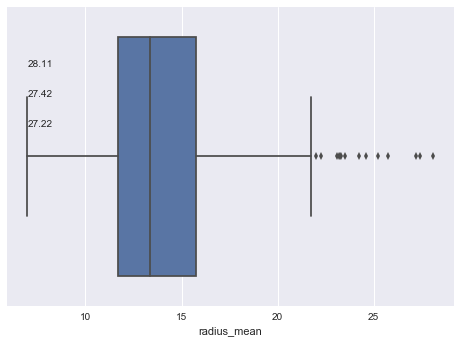

texture_mean


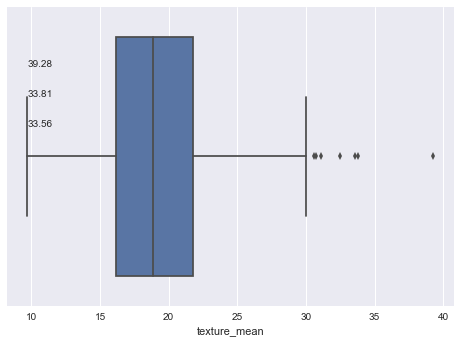

perimeter_mean


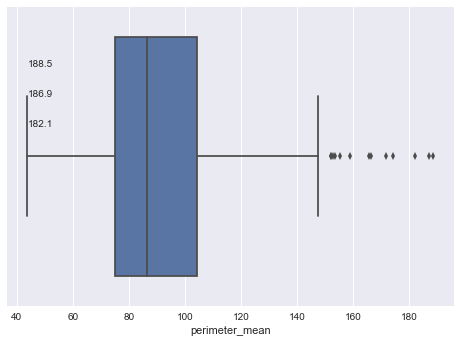

area_mean


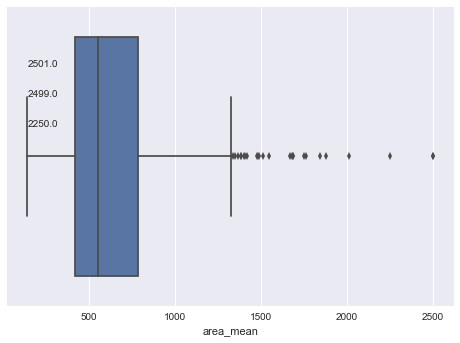

smoothness_mean


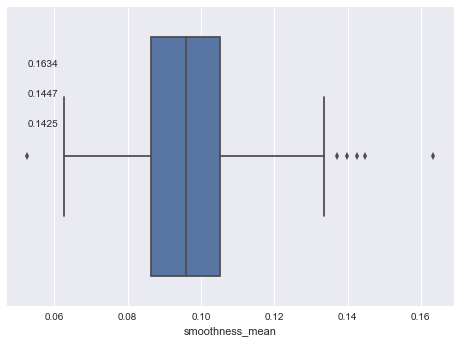

compactness_mean


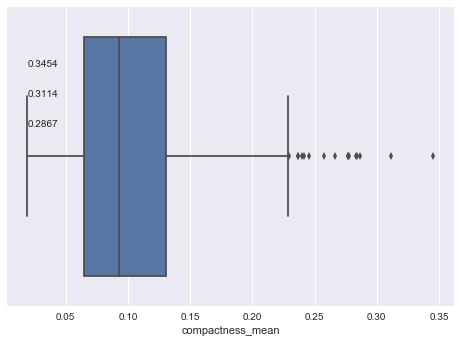

concavity_mean


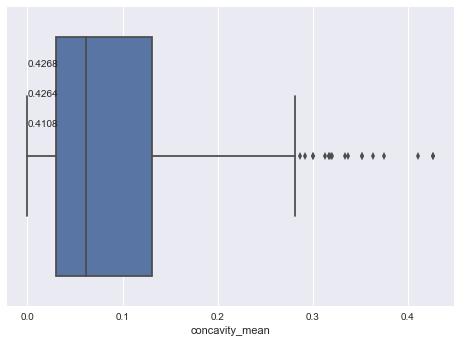

concave points_mean


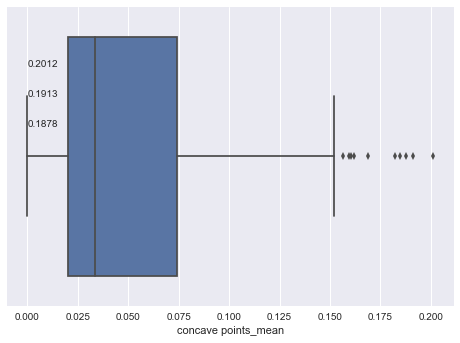

symmetry_mean


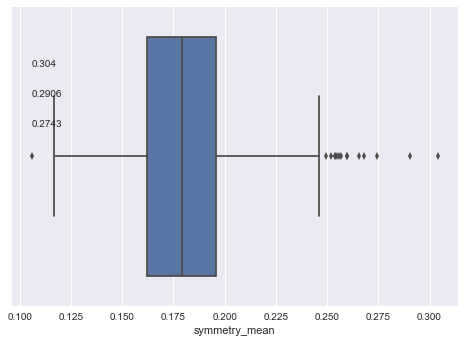

fractal_dimension_mean


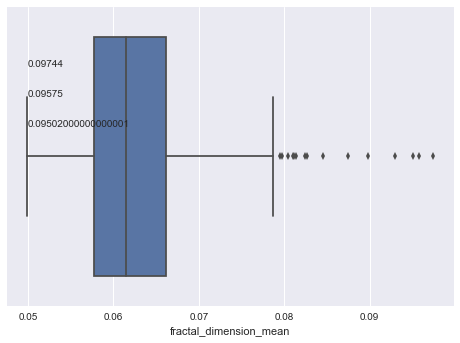

radius_se


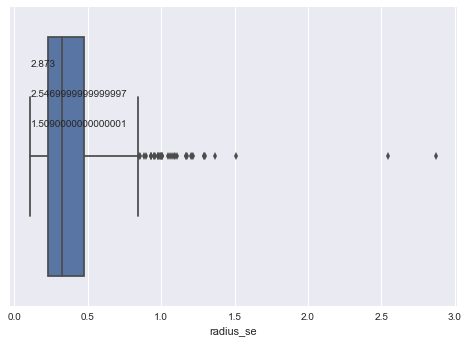

texture_se


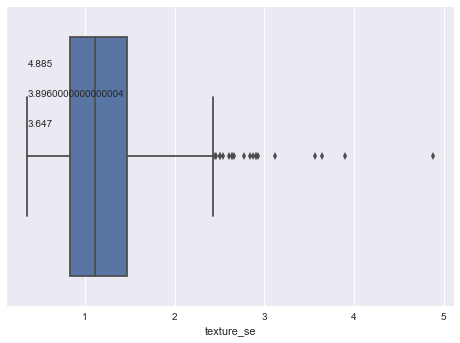

perimeter_se


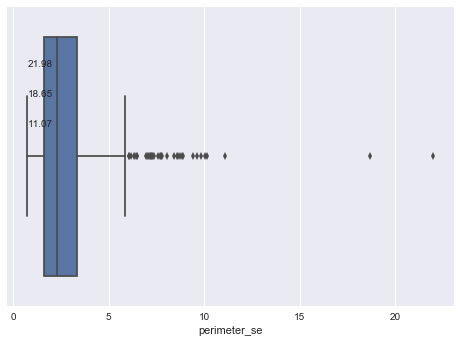

area_se


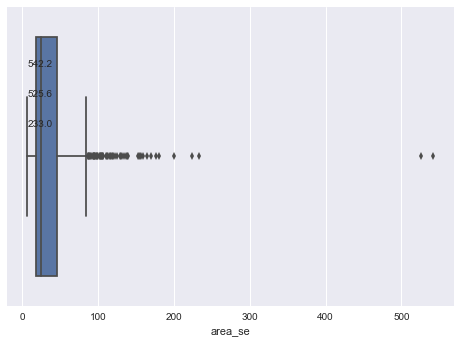

smoothness_se


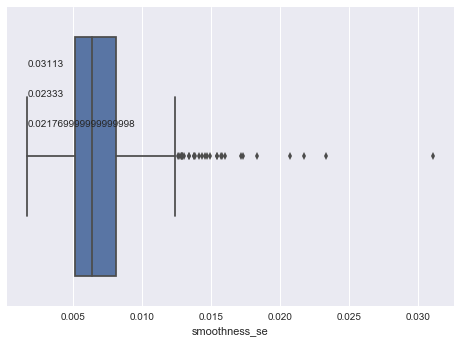

compactness_se


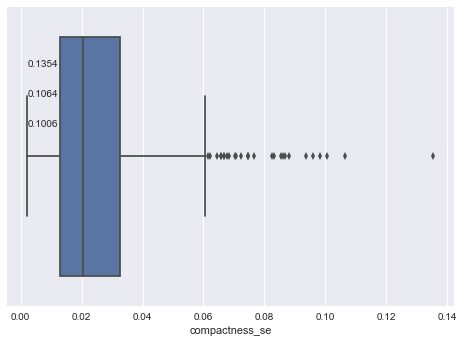

concavity_se


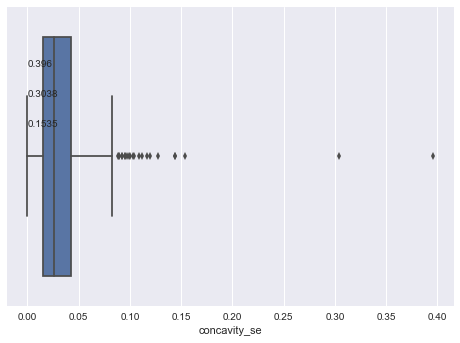

concave points_se


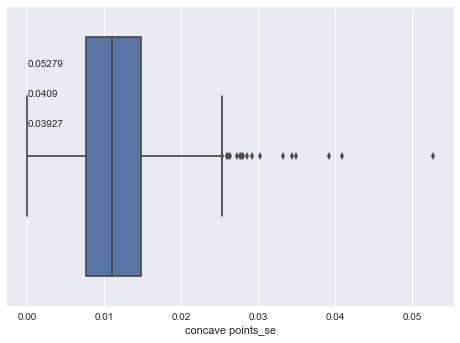

symmetry_se


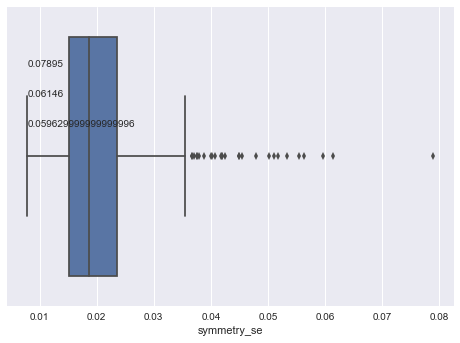

fractal_dimension_se


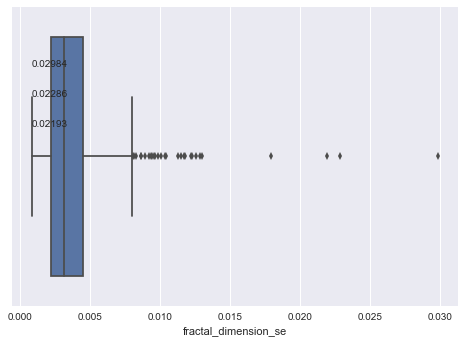

radius_worst


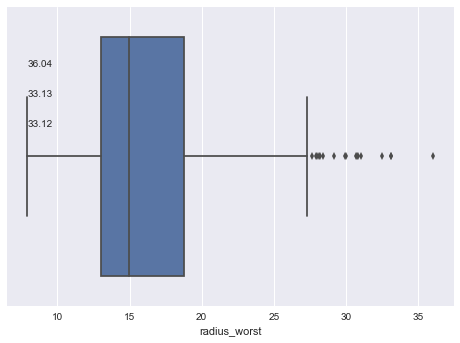

texture_worst


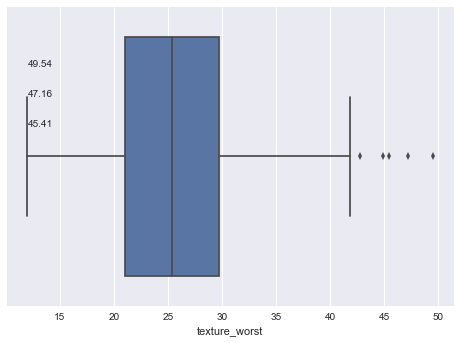

perimeter_worst


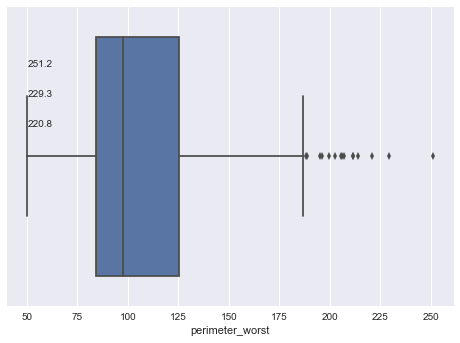

area_worst


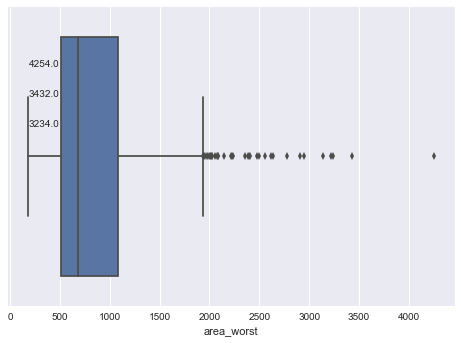

smoothness_worst


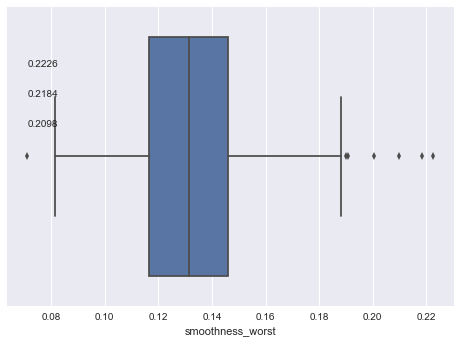

compactness_worst


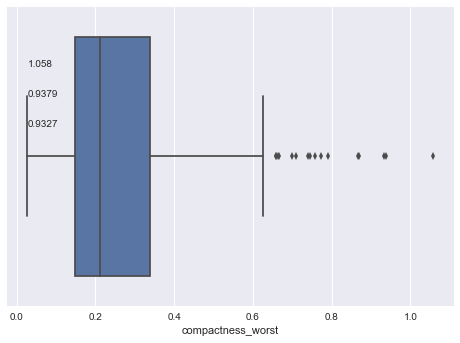

concavity_worst


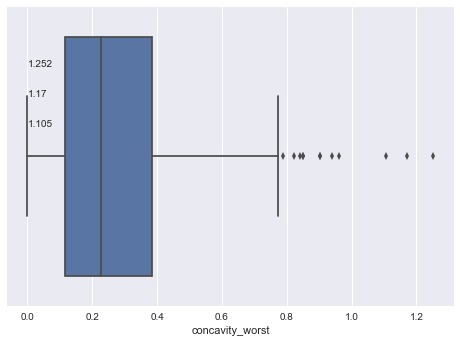

concave points_worst


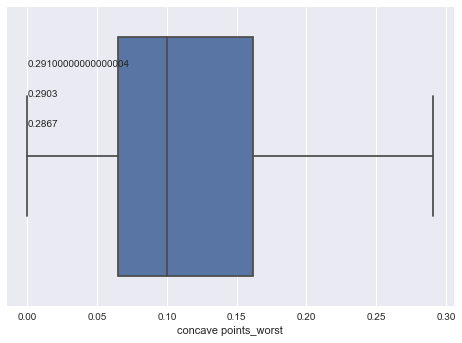

symmetry_worst


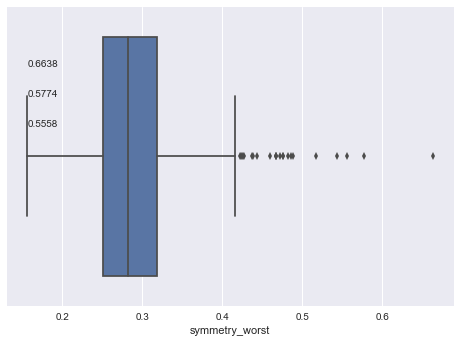

fractal_dimension_worst


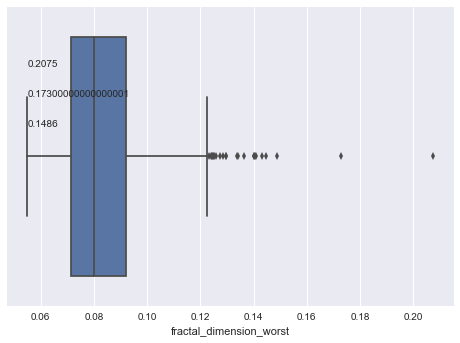

In [113]:
for i in df.columns.values[2:]:
    print(i)
    sns.boxplot(df[i])

    # Print the three highest values
    highest_vals = list(df[i].nlargest(3)) # get 3 highest values

    smallest_val = min(df[i])

    plt.text(smallest_val, -0.3, highest_vals[0])
    plt.text(smallest_val, -0.2, highest_vals[1])
    plt.text(smallest_val, -0.1, highest_vals[2])

    plt.show()

## Correlation Analysis

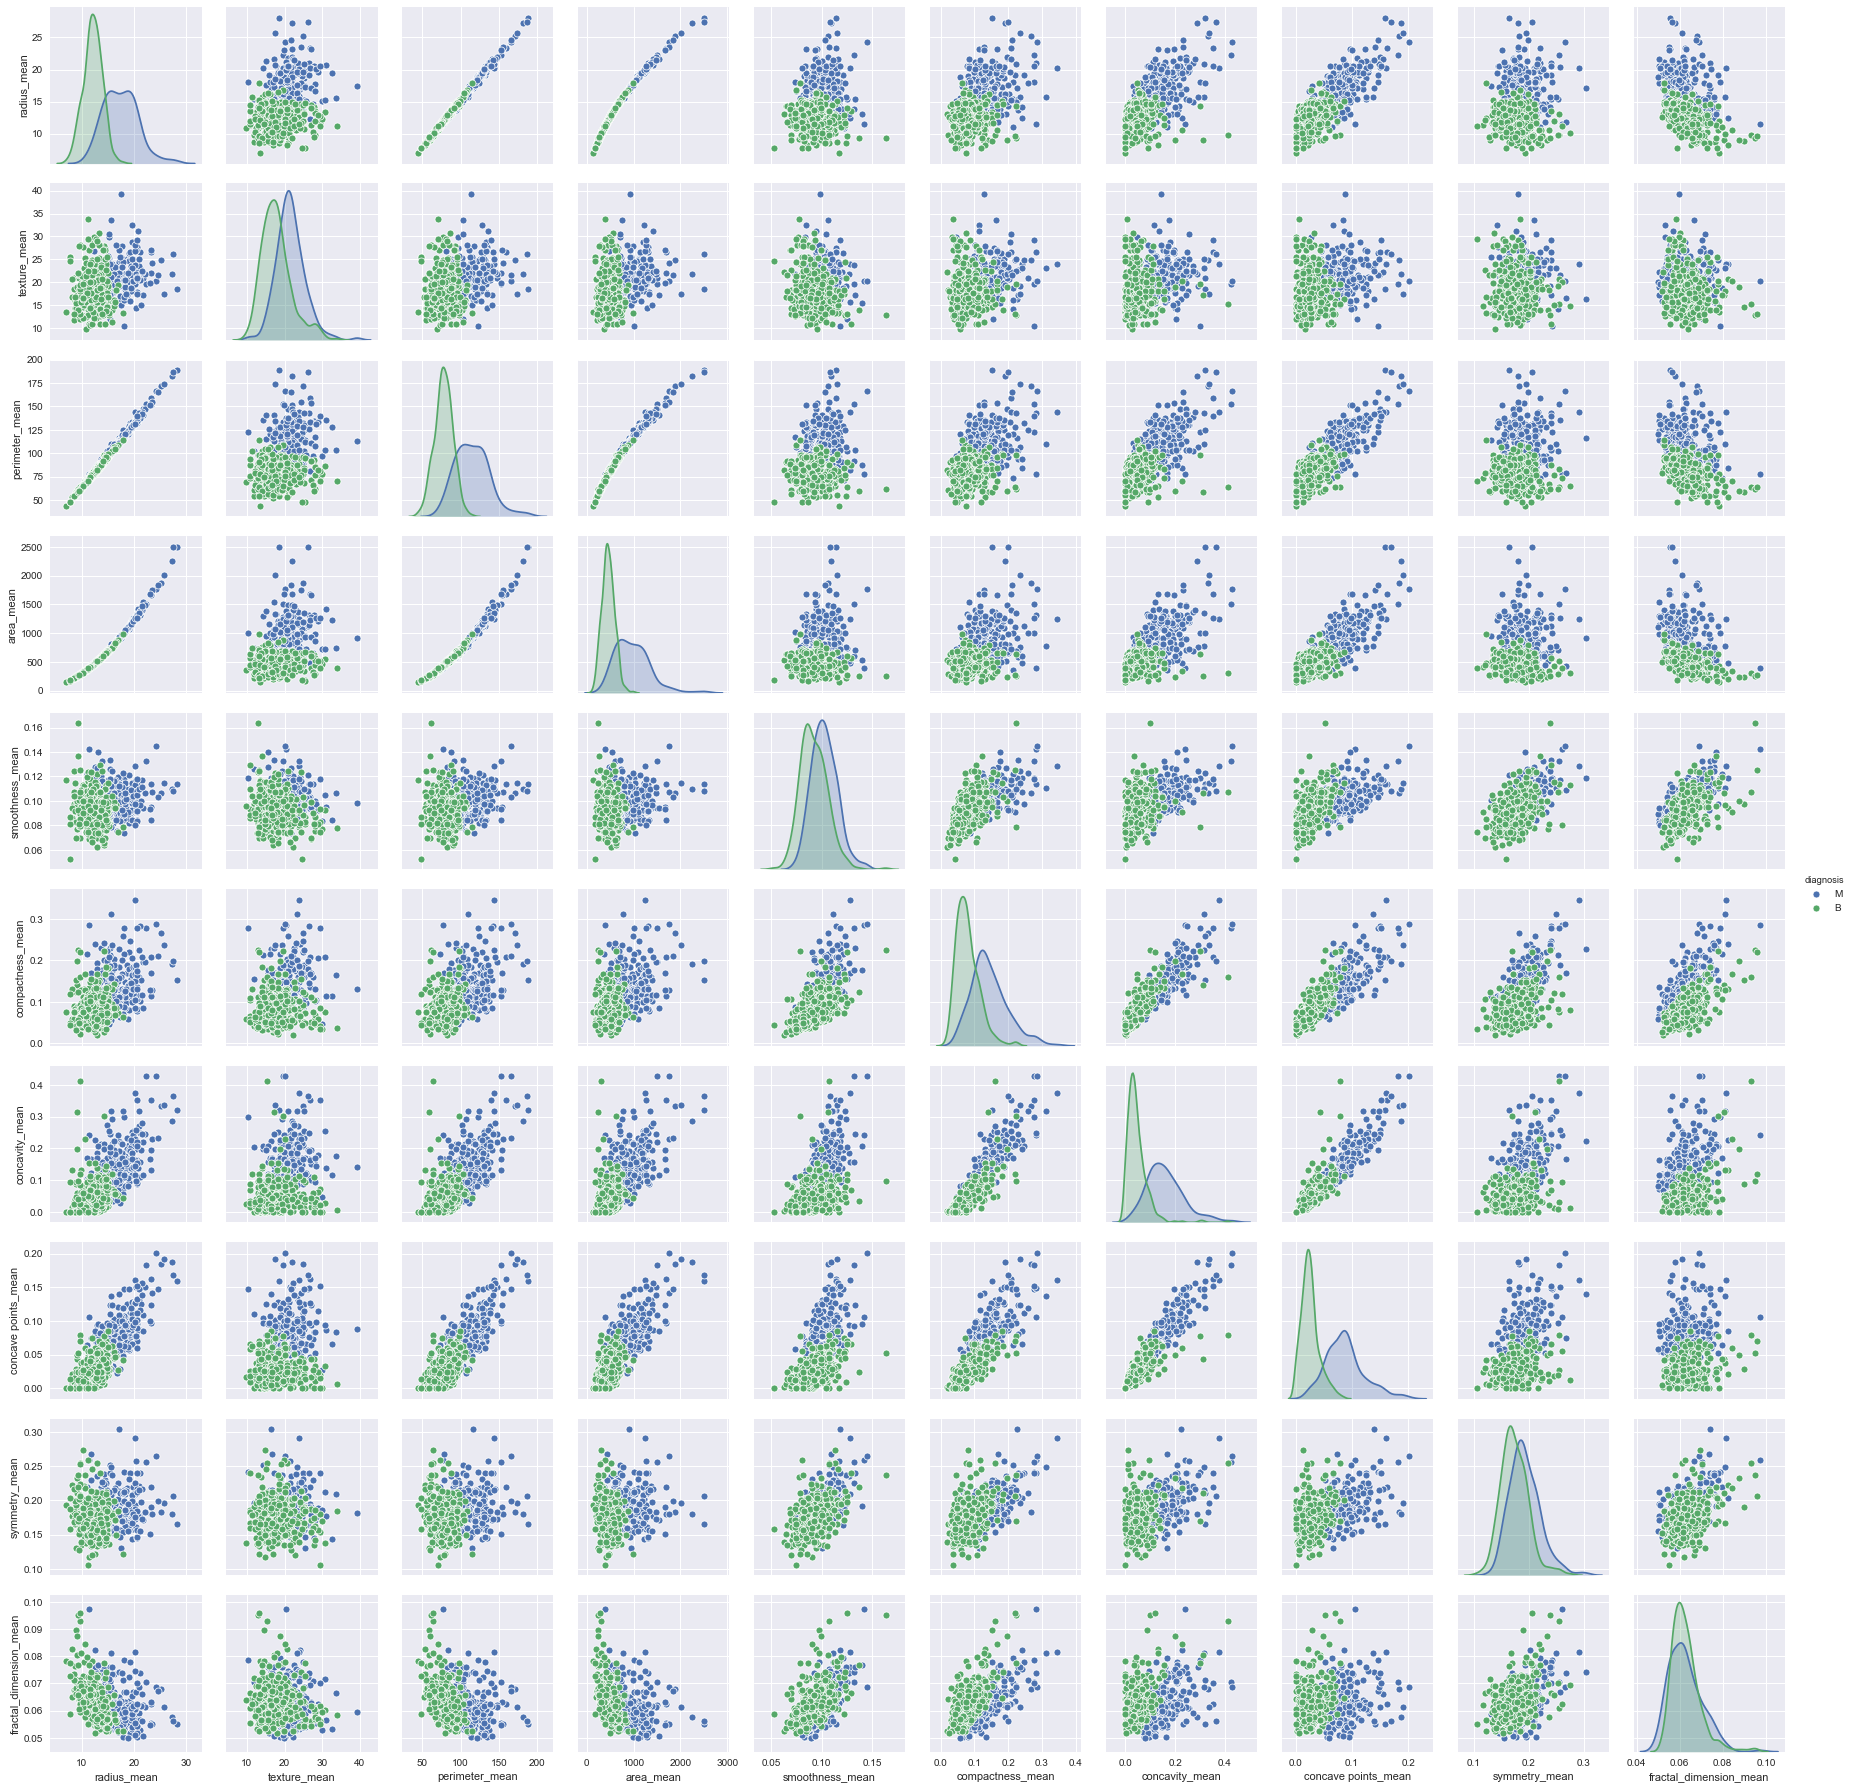

In [114]:
# Viewing how they are correlated with each other
sns.pairplot(df, hue='diagnosis' ,vars=df.columns.values[2:12])

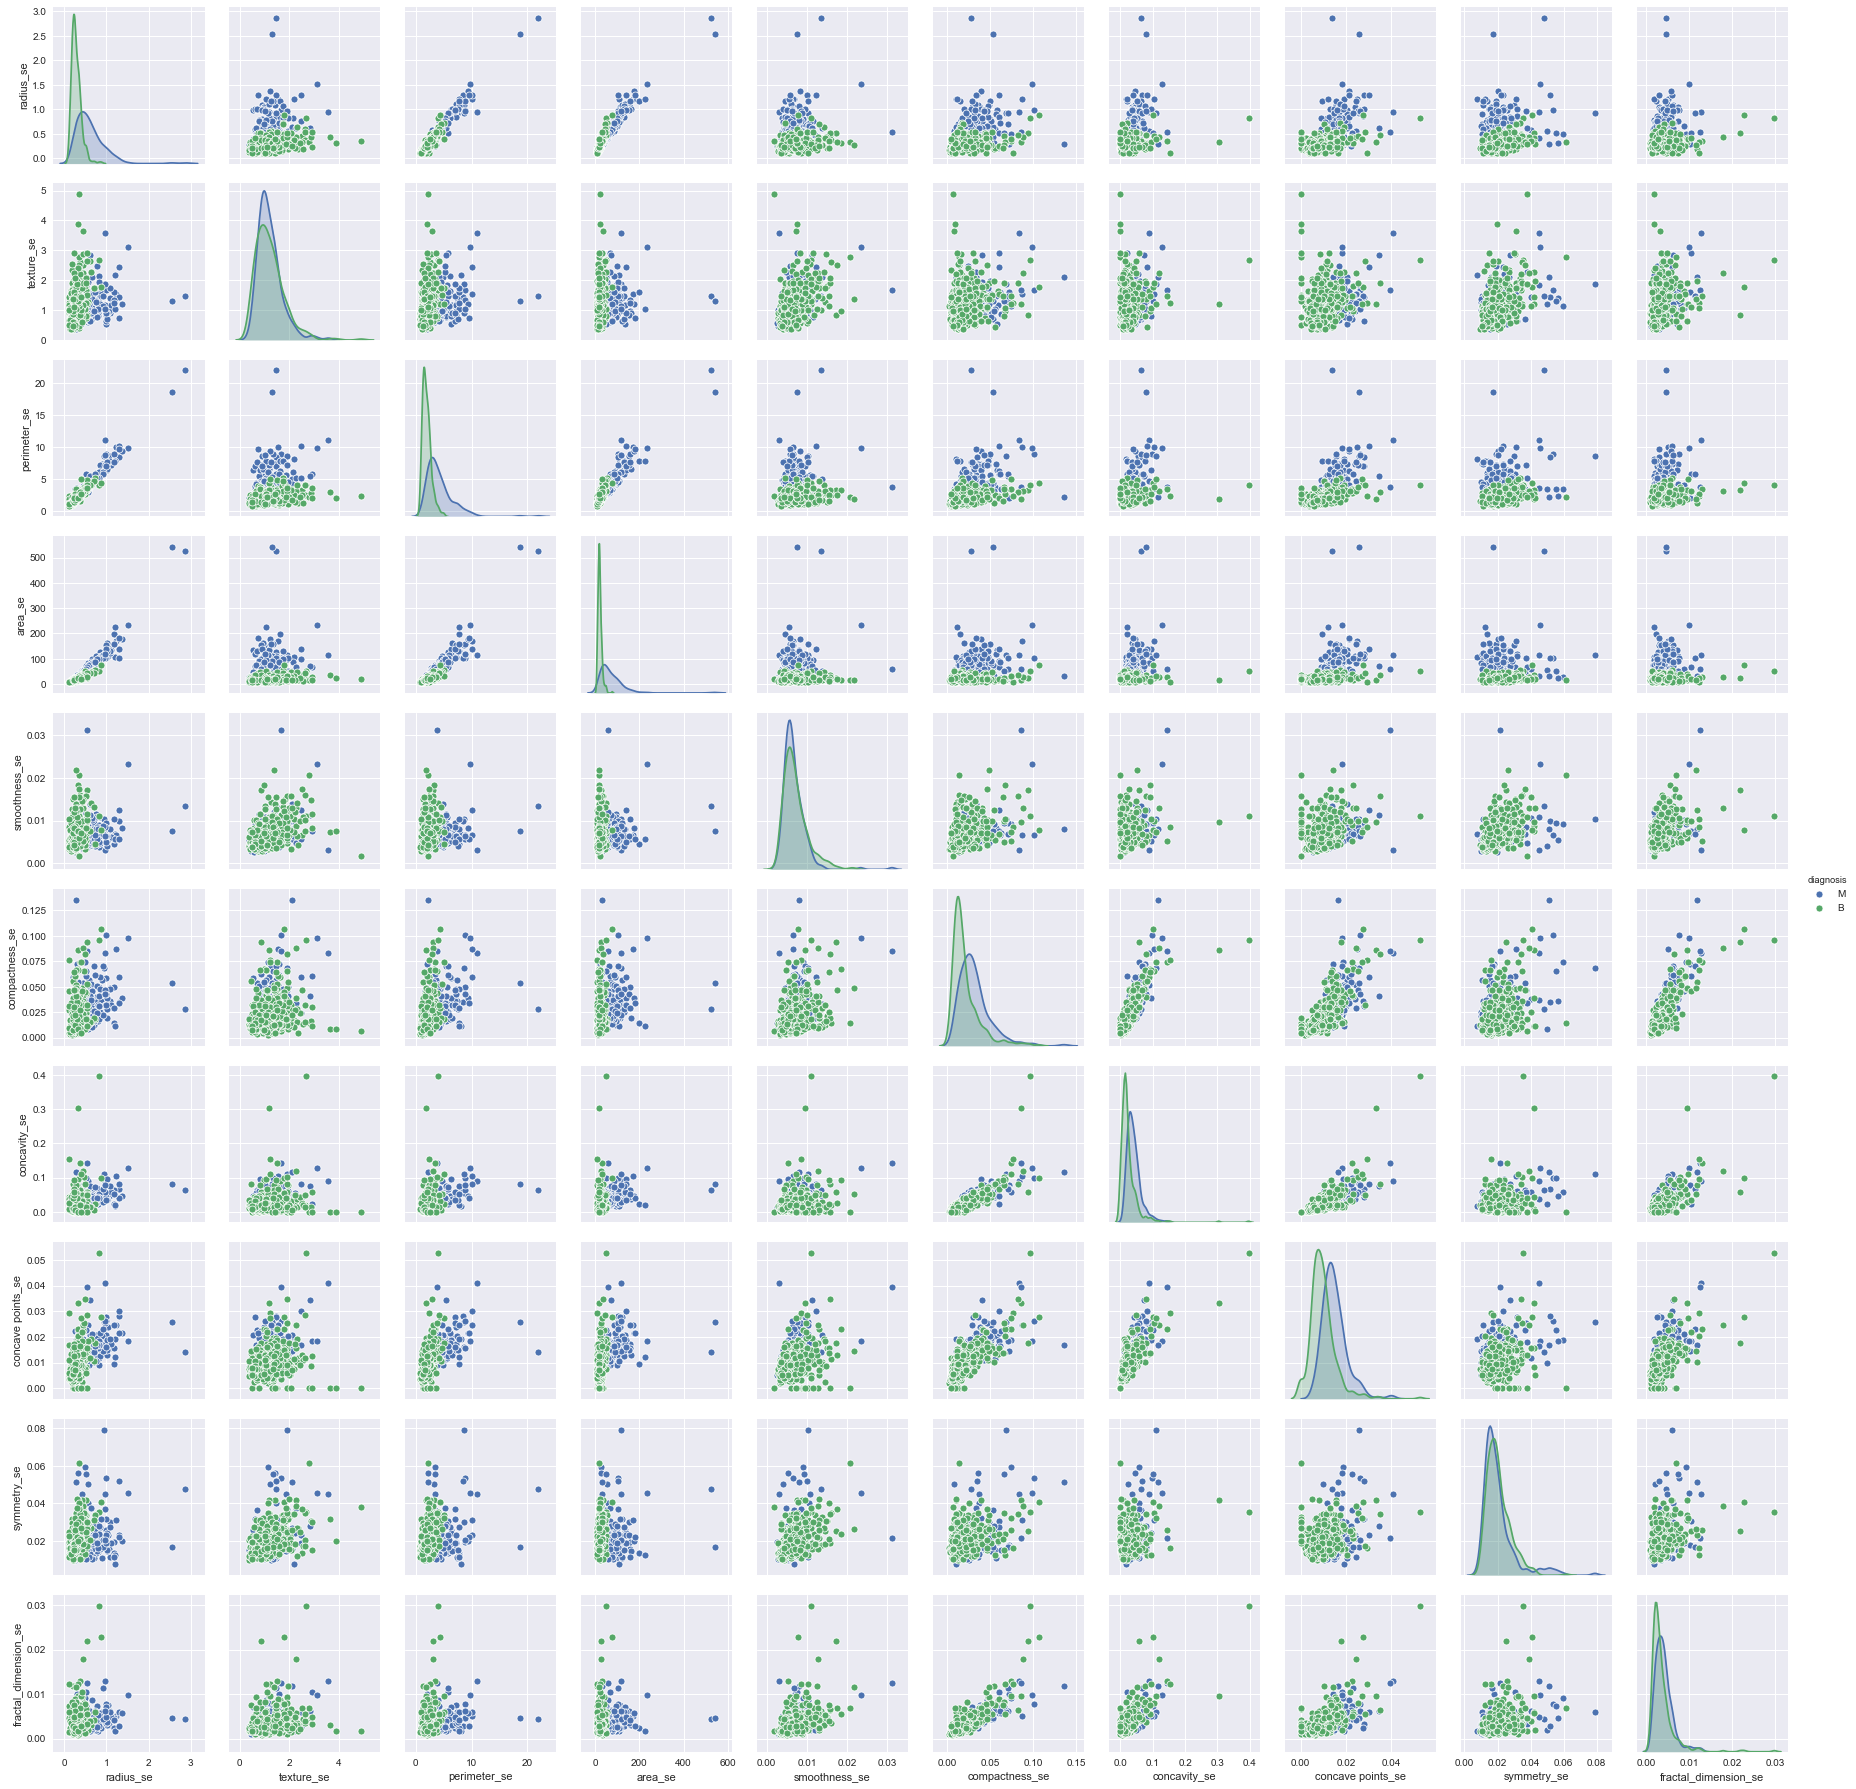

In [115]:
sns.pairplot(df, hue='diagnosis' ,vars=df.columns.values[12:22])

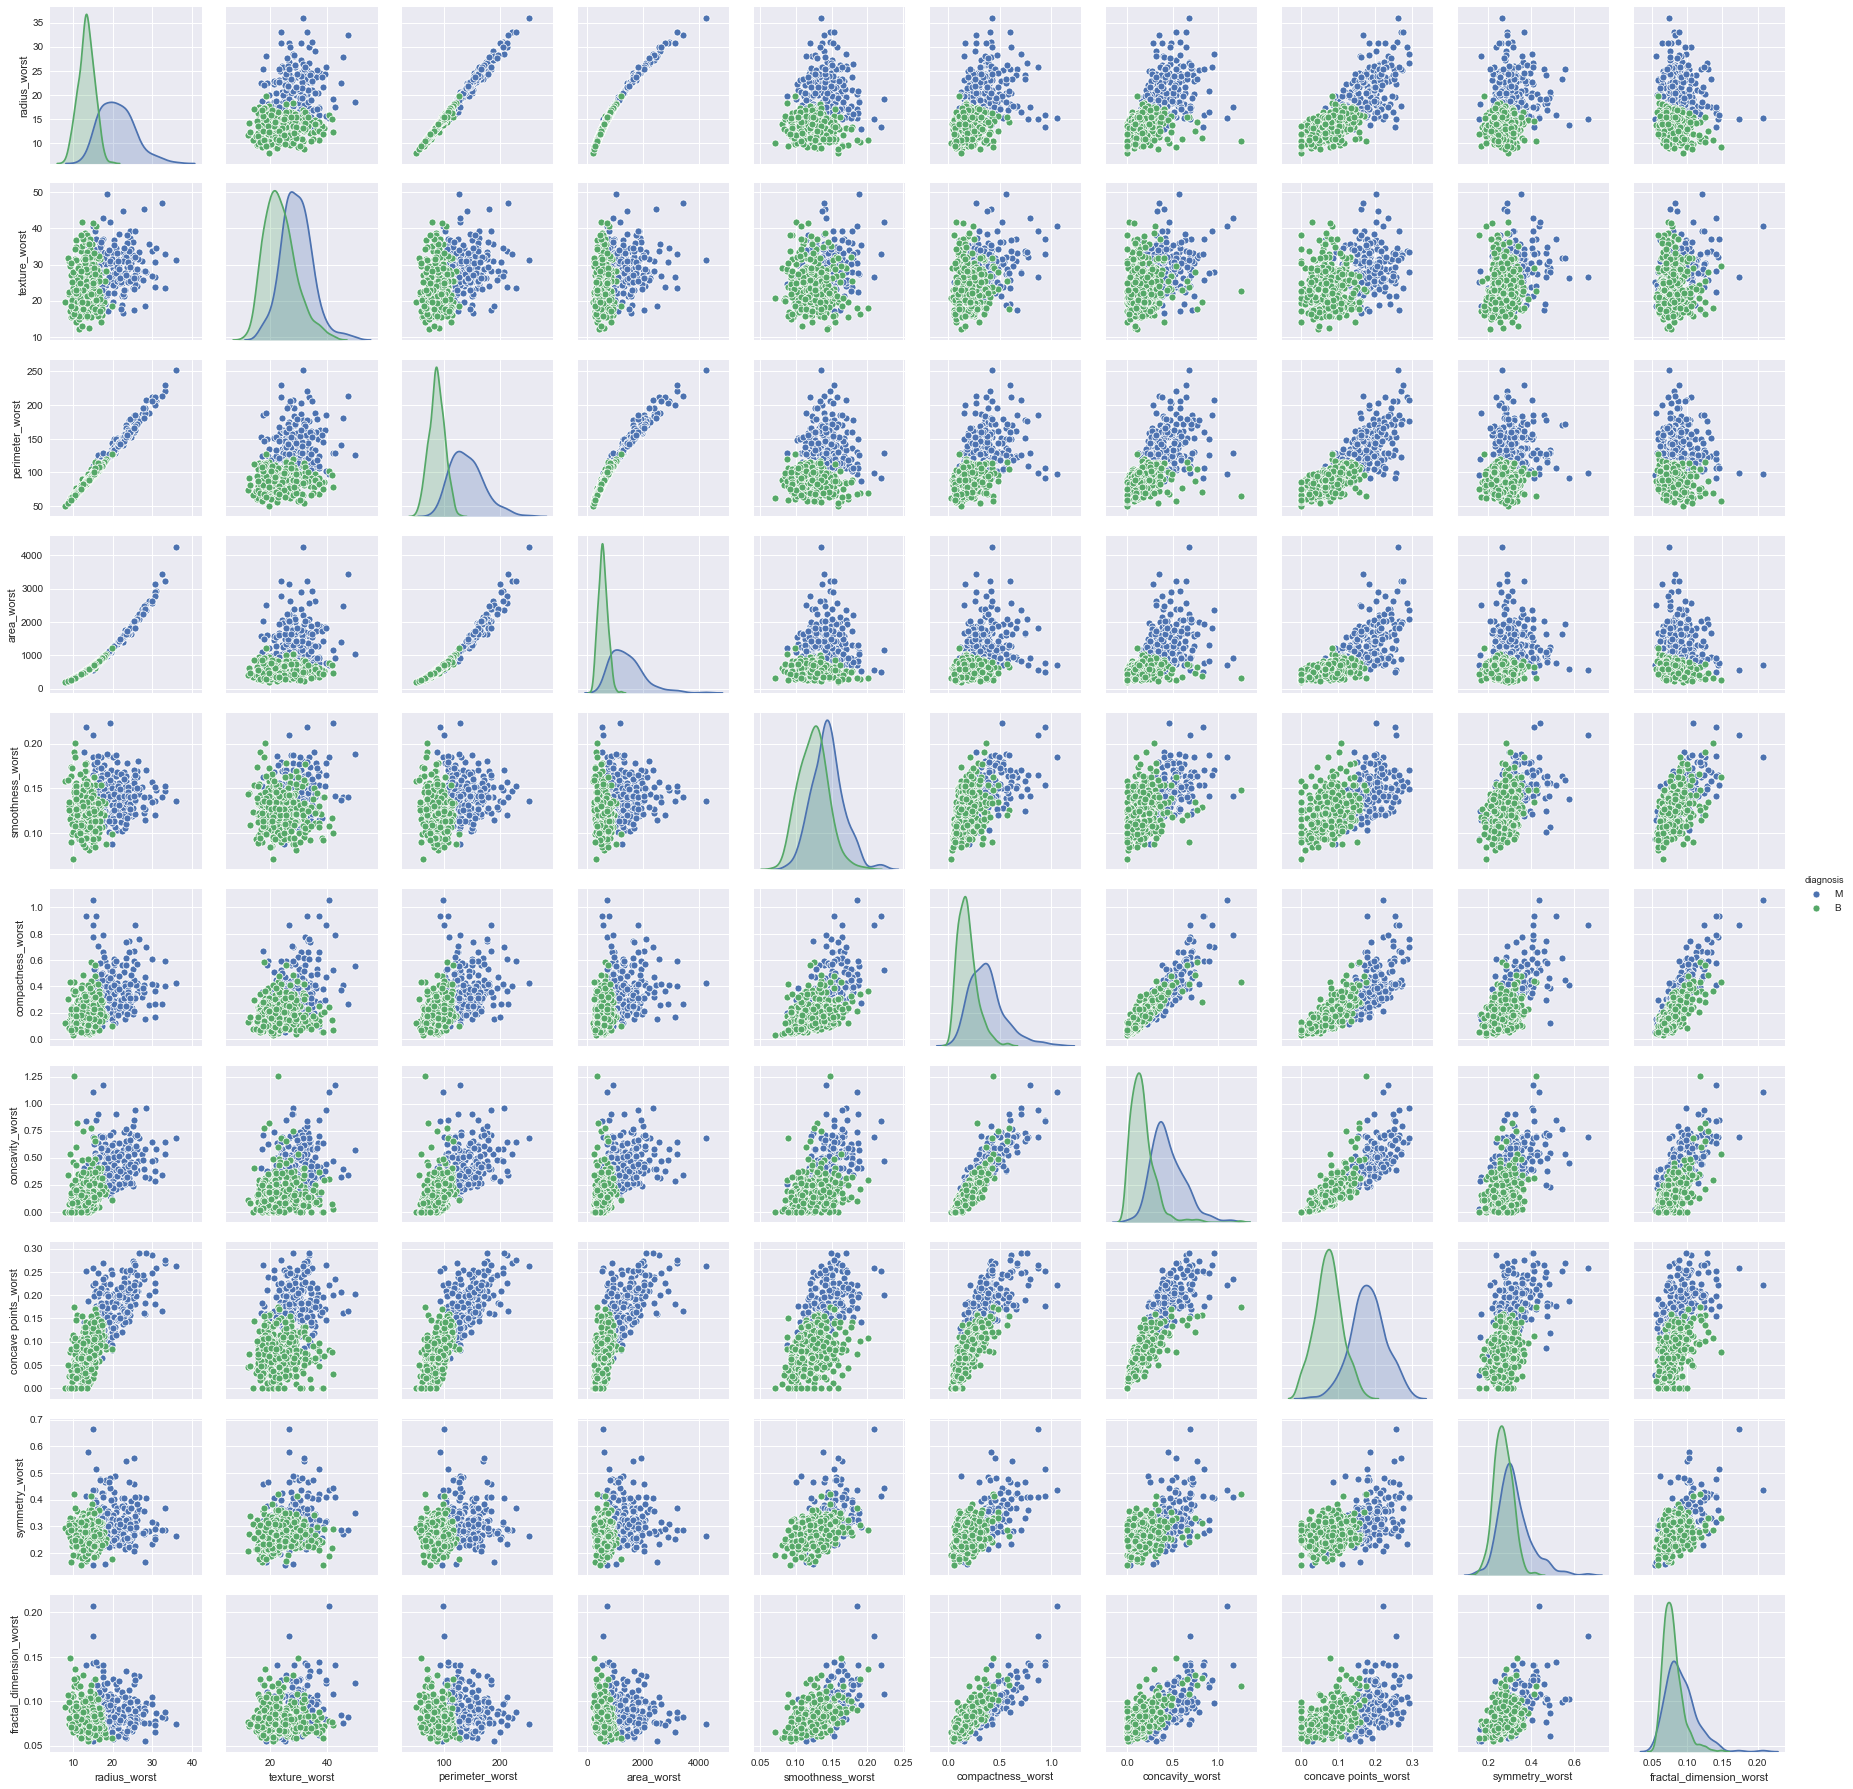

In [116]:
sns.pairplot(df, hue='diagnosis' ,vars=df.columns.values[22:])

## Dimensionality Reduction

### PCA

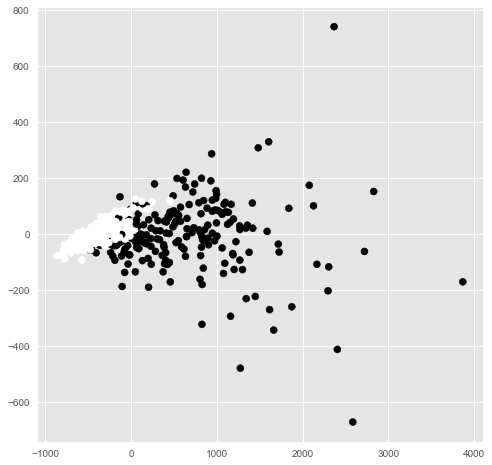

In [120]:
from sklearn.decomposition import PCA

X = df.iloc[:,2:].as_matrix()
y= pd.get_dummies(df['diagnosis'])['M'].as_matrix()


pca = PCA(n_components=2)
pca_dimensions = pca.fit_transform(X)
plt.figure(figsize = (8,8))
plt.style.use('ggplot')
plt.scatter(pca_dimensions[:,0], pca_dimensions[:,1], c=y)
plt.show()

### PCA helps us to identify the naked patterns with the data and in this graph, we can see that we have two clear clusters of the data. Most likely, they relates with the pairplots where we saw good clusters getting formed with the benign and malign labels.

In [121]:
pca.explained_variance_ratio_

array([0.98204467, 0.01617649])

### The first component is able to explain the 98% of the variance, which is excellent.

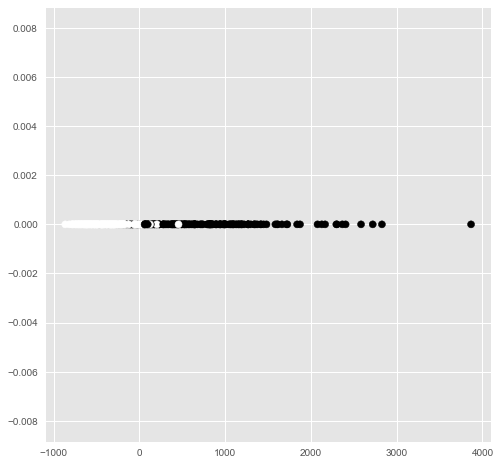

In [123]:
single_dim_pca = PCA(n_components=1)
single_dimension = single_dim_pca.fit_transform(X)
y_axis_all_zeros = np.zeros(len(single_dimension))
plt.figure(figsize = (8,8))
plt.style.use('ggplot')
plt.scatter(single_dimension[:,0], y_axis_all_zeros, c=y)
plt.show()

In [88]:
single_dim_pca.explained_variance_ratio_

array([0.44272026])

### T-SNE

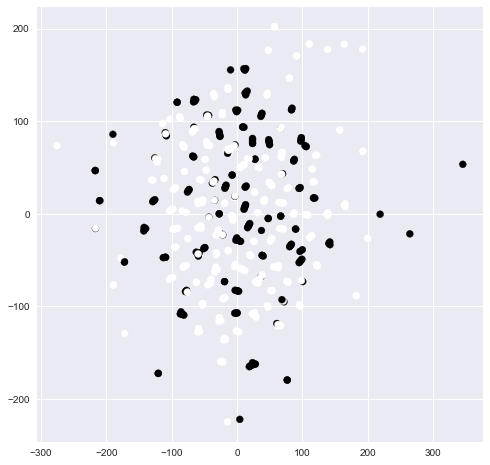

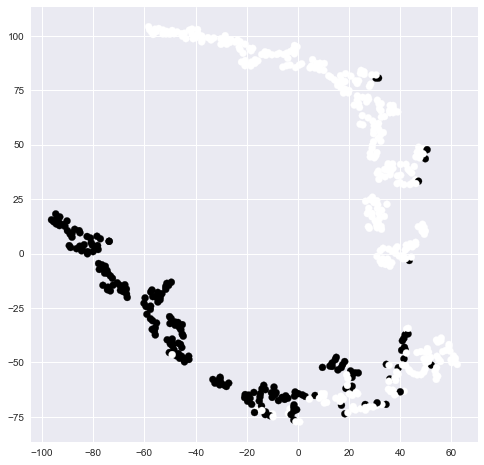

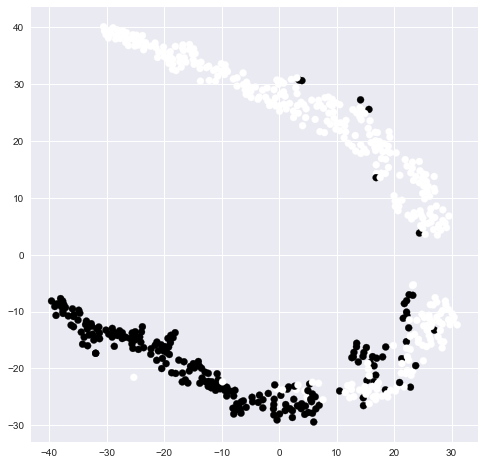

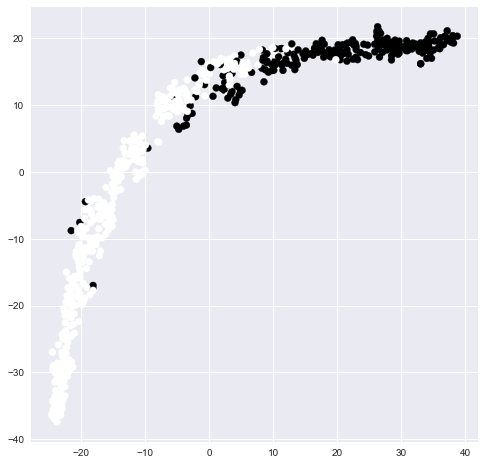

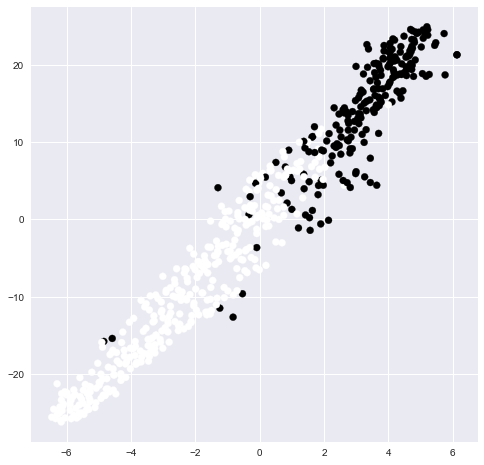

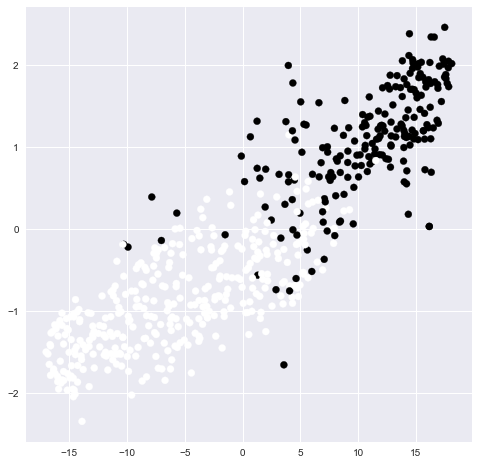

In [124]:
from sklearn.manifold import TSNE

perplexities = [1,10,25,40,70,100]

for p in perplexities:
    tsne = TSNE(n_components=2, perplexity=p, n_iter=5000)
    feature_vectors_tsne2d = tsne.fit_transform(X)
    plt.figure(figsize = (8,8))
    plt.style.use('seaborn')
    plt.scatter(feature_vectors_tsne2d[:, 0], feature_vectors_tsne2d[:, 1], c=y)
    plt.show()

### The above graph shows the possible non-linear relationships in the features over a high dimension. PCA works on mathematical approach (co-variance, eigen vector and eigen value) but t-SNE works on probabilistic approach to pick up the most probable points in the feature space. It can help us to spot the non-linearities in the data set.

In [90]:
df = pd.read_csv('data.csv')
print ("Rows     : " ,df.shape[0])
print ("Columns  : " ,df.shape[1])
print ("\nFeatures : \n" ,df.columns.tolist())
print ("\nUnique values :  \n",df.nunique())

Rows     :  569
Columns  :  33

Features : 
 ['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32']

Unique values :  
 id                         569
diagnosis                    2
radius_mean                456
texture_mean               479
perimeter_mean             522
area_mean                  539
smoothness_mean            474
compactness_mean           537
concavity_mean             537
concave points_mean        542
symmetry_mean              432
fractal_dimens

  diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0         M     1.096100     -2.071512        1.268817   0.983510   
1         M     1.828212     -0.353322        1.684473   1.907030   
2         M     1.578499      0.455786        1.565126   1.557513   
3         M    -0.768233      0.253509       -0.592166  -0.763792   
4         M     1.748758     -1.150804        1.775011   1.824624   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0         1.567087          3.280628        2.650542             2.530249   
1        -0.826235         -0.486643       -0.023825             0.547662   
2         0.941382          1.052000        1.362280             2.035440   
3         3.280667          3.399917        1.914213             1.450431   
4         0.280125          0.538866        1.369806             1.427237   

   symmetry_mean  fractal_dimension_mean  
0       2.215566                2.253764  
1       0.001391               -0.86

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

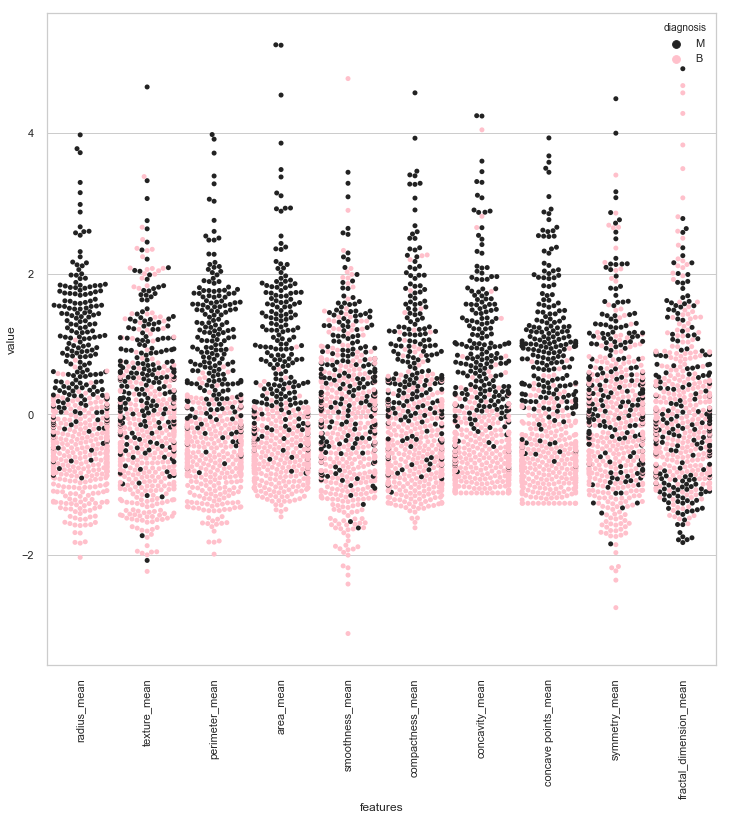

In [91]:
# y includes our labels and x includes our features
target = df.diagnosis                          # M or B 
features = df.drop(['Unnamed: 32','id','diagnosis'],axis = 1 )

sns.set(style="whitegrid", palette="muted")
bc_target = target
bc_features = features
bc_features_scaled = (bc_features - bc_features.mean()) / (bc_features.std())
bc_swarm = pd.concat([bc_target,bc_features_scaled.iloc[:,0:10]],axis=1)
print(bc_swarm.head())
bc_swarm = pd.melt(bc_swarm,
                   id_vars="diagnosis",
                   var_name="features",
                   value_name='value')
print("********************************")
print(bc_swarm.head())
plt.figure(figsize=(12,12))
sns.swarmplot(x="features", y="value", hue="diagnosis", data = bc_swarm, color='pink')
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

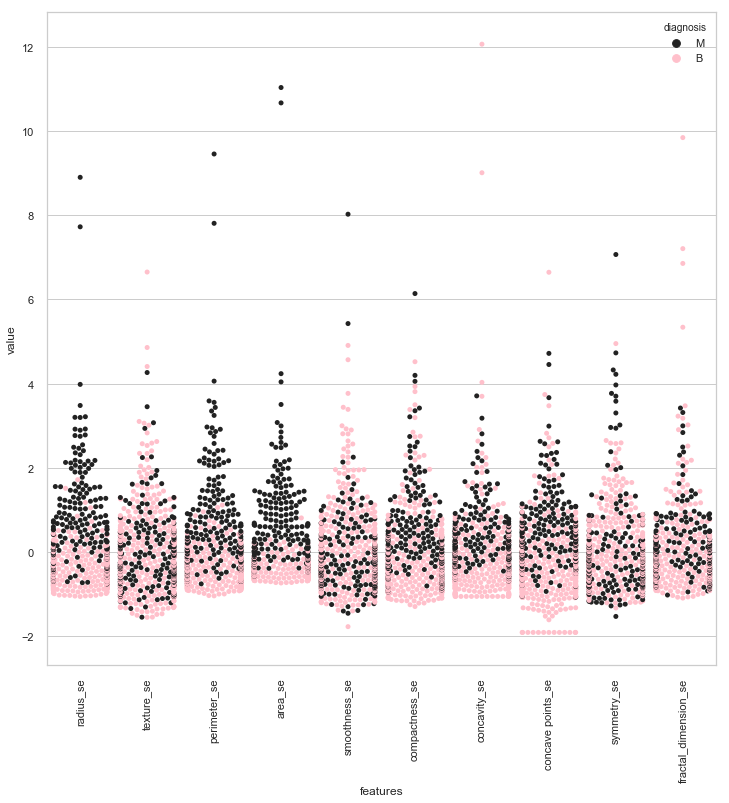

In [92]:
bc_swarm1 = pd.concat([bc_target,bc_features_scaled.iloc[:,10:20]],axis=1)

bc_swarm = pd.melt(bc_swarm1,
                   id_vars="diagnosis",
                   var_name="features",
                   value_name='value')
plt.figure(figsize=(12,12))
sns.swarmplot(x="features", y="value", hue="diagnosis", data = bc_swarm, color='pink')
plt.xticks(rotation=90)

#### After looking at the features, we can see really good clusters and those will be helpful in determining which clusters we want to choose for machine learning part. There are many features which are not quite separable, such as the texture, symmetry and fractal dimension. We will try to plot them in the 3D scatter plots to determine whether the clusters are separable of not. This is very important to do the feature enginnering for the models.

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

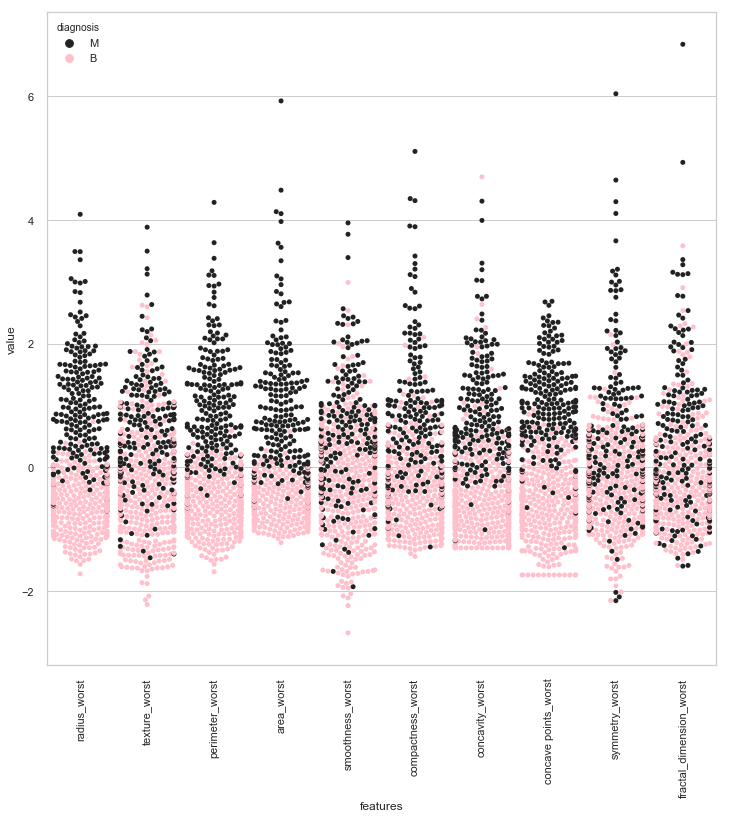

In [93]:
bc_swarm = pd.concat([bc_target,bc_features_scaled.iloc[:,20:31]],axis=1)
bc_swarm = pd.melt(bc_swarm,
                   id_vars="diagnosis",
                   var_name="features",
                   value_name='value')
plt.figure(figsize=(12,12))
sns.swarmplot(x="features", y="value", hue="diagnosis", data = bc_swarm, color='pink')
plt.xticks(rotation=90)

In [94]:
bc_swarm = pd.concat([bc_target,bc_features_scaled],axis=1)
bc_malign = bc_swarm[bc_swarm['diagnosis'] == 'M']
bc_benign = bc_swarm[bc_swarm['diagnosis'] == 'B']

plot_3d_relation(bc_malign,'smoothness_mean','symmetry_mean','fractal_dimension_mean')

plot_3d_relation(bc_malign,'texture_se','smoothness_se','symmetry_se')

### This 3D scatter plot shows that the features which were not separable in the swarmplot, are separable when plotted in a 3D space. We can clearly see the clusters and we can firmly say that if we look at them together, it can provide the doctors crucial insights.

In [95]:
#Pearson correlation
correlation = bc_swarm.corr()
#tick labels
matrix_cols = correlation.columns.tolist()
#convert to array
corr_array  = np.array(correlation)

#Plotting
trace = go.Heatmap(z = corr_array,
                   x = matrix_cols,
                   y = matrix_cols,
                   colorscale = "Viridis",
                   colorbar   = dict(title = "Pearson Correlation coefficient",
                                     titleside = "right"
                                    ) ,
                  )

layout = go.Layout(dict(title = "Correlation Matrix for variables",
                        autosize = False,
                        height  = 720,
                        width   = 800,
                        margin  = dict(r = 0 ,l = 210,
                                       t = 25,b = 210,
                                      ),
                        yaxis   = dict(tickfont = dict(size = 9)),
                        xaxis   = dict(tickfont = dict(size = 9))
                       )
                  )

data1 = [trace]
fig = go.Figure(data=data1,layout=layout)
py.iplot(fig)

### Figuring out the importance of each feature

Features sorted by their score:


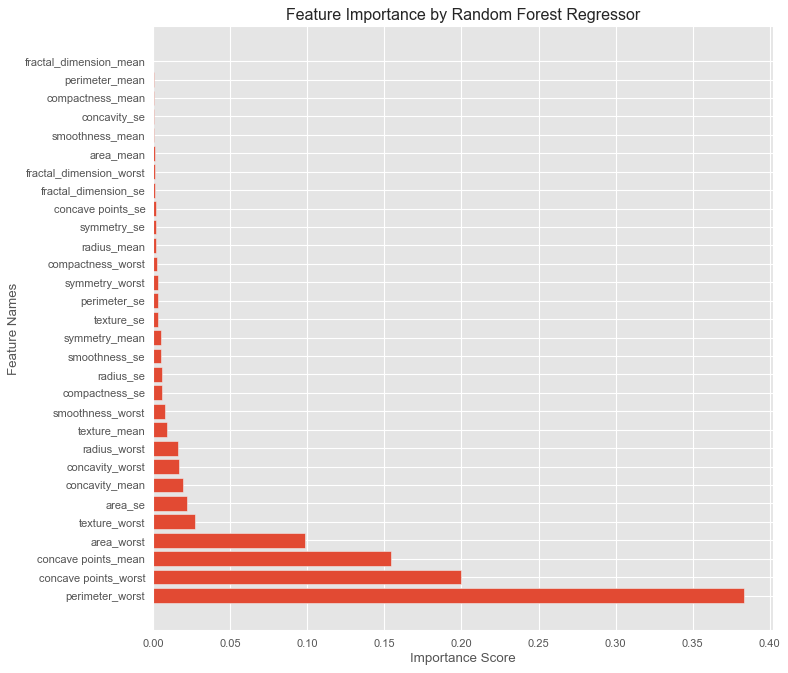

In [127]:
# Creating a safe copy
bc_swarm = pd.concat([bc_target,bc_features_scaled],axis=1)

bc_swarm_imp = bc_swarm

bc_swarm_imp['diagnosis'] = bc_swarm_imp['diagnosis'].map({'M':1, 'B':0})

cols = list(bc_swarm_imp.columns)

# Deleting the diagnosis problem
del cols[0]
Y = bc_swarm_imp['diagnosis'].values
X = bc_swarm_imp[cols].values
names = np.array(cols)
rf = RandomForestRegressor()
rf.fit(X, Y)
print("Features sorted by their score:")
feature_data = sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), 
             reverse=True)

feature_dataframe = pd.DataFrame(feature_data)


figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
plt.style.use('ggplot')
plt.xlabel('Importance Score')
plt.ylabel('Feature Names')
plt.title('Feature Importance by Random Forest Regressor')
plt.barh(feature_dataframe[1], feature_dataframe[0])
plt.show()

#### Split Data

In [97]:
data = spark.read.csv('data.csv', header='true', inferSchema='true')
data = data.select([column for column in data.columns if column not in ['_c32', 'id']])
all_features = [x for x in data.columns if x not in ['diagnosis']]

In [98]:
(trainingData, testData) = data.randomSplit([0.7, 0.3])

#### CV Model and Results

In [99]:
# model score lists
Models = []
Accuracy = []
AUC = []
F1 = []
Precision = []
Recall = []

In [100]:
def fit_classification(model, params=None, features=all_features,numFolds=2, model_name='model'):
    
    # Prepare Data
    label_indexer = StringIndexer(inputCol = "diagnosis", outputCol = "label")
    assembler = VectorAssembler(
        inputCols=[x for x in data.columns if x in features],
        outputCol='features')
    pipeline = Pipeline(stages=[assembler,label_indexer])
    pf = pipeline.fit(data)
    train = pf.transform(trainingData)
    test = pf.transform(testData)
    
    # Train Model
    crossval = CrossValidator(estimator=model,
                              estimatorParamMaps=paramGrid,
                              evaluator=BinaryClassificationEvaluator(),
                              numFolds=numFolds)
    cvModel = crossval.fit(train)
    print('CV Average Metrics: ', cvModel.avgMetrics)
    
    best_model = cvModel.bestModel

    try:
        trainingSummary = best_model.summary
        
        # Obtain the receiver-operating characteristic as a dataframe and areaUnderROC.
#         print("\nareaUnderROC: " + str(trainingSummary.areaUnderROC))

#         plt.figure(figsize=(5,5))
#         plt.plot([0, 1], [0, 1], 'r--')
#         plt.plot(trainingSummary.roc.select('FPR').collect(),
#                  trainingSummary.roc.select('TPR').collect())
#         plt.xlabel('FPR')
#         plt.ylabel('TPR')
#         plt.title('ROC')
#         plt.show()


#         plt.figure(figsize=(5,5))
#         plt.plot([0, 1], [0, 1], 'r--')
#         plt.plot(trainingSummary.pr.select('recall').collect(),
#                  trainingSummary.pr.select('precision').collect())
#         plt.xlabel('recall')
#         plt.ylabel('precision')
#         plt.title('PRC')
#         plt.show()

        # Set the model threshold to maximize F-Measure
        fMeasure = trainingSummary.fMeasureByThreshold
        maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
        bestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
            .select('threshold').head()['threshold']
        best_model.setThreshold(1)
        print('Best Threshold: ',bestThreshold)
        
    except:
        #Set Best Threshold
        y_train_pred = best_model.transform(train)
        train_pred = [int(row['prediction']) for row in y_train_pred.select('prediction').collect()]
        train_labels = [int(row['label']) for row in y_train_pred.select('label').collect()]
        train_prob = [list(row['probability']) for row in y_train_pred.select('probability').collect()]
        train_prob = np.array(train_prob)[:,1]
        train_labels = np.array(train_labels)
        fpr_train, tpr_train, thresholds_train = roc_curve(train_labels, train_prob)
        
        
        true_pos_train = tpr_train*(train_labels.sum())
        true_neg_train = (1 - fpr_train) *(1-train_labels).sum()
        false_pos_train = fpr_train *(1-train_labels).sum()
        false_neg_train = (1 - tpr_train) *(train_labels.sum())
        
        
        best_threshold_index = np.argmax(true_pos_train + true_neg_train)
        best_threshold = 1 if best_threshold_index == 0 else thresholds_train[ best_threshold_index ]
        
        print("Accuracy-maximizing threshold was: " + str(best_threshold))
        
    
        best_threshold_index = np.argmax(true_pos_train /(true_pos_train+false_neg_train+false_pos_train))
        best_threshold = 1 if best_threshold_index == 0 else thresholds_train[ best_threshold_index ]
        
        print("f1-maximizing threshold was: " + str(best_threshold))
        
        best_threshold_index = np.argmax(true_pos_train/(true_pos_train+false_neg_train))
        best_threshold = 1 if best_threshold_index == 0 else thresholds_train[ best_threshold_index ]
        
        print("recall-maximizing threshold was: " + str(best_threshold))
            
        best_model.setThreshold = best_threshold


      
            
        
    # Print results on test
    y_pred = best_model.transform(test)
    predictions = [int(row['prediction']) for row in y_pred.select('prediction').collect()]
    labels = [int(row['label']) for row in y_pred.select('label').collect()]
    probs = [list(row['probability']) for row in y_pred.select('probability').collect()]
    probs = np.array(probs)[:,1]
    
    # Show ROC Curve
    fpr, tpr, thresholds = roc_curve(labels, probs, pos_label=1)
    figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')
    plt.style.use('seaborn')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.plot(fpr, tpr)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC')
    plt.show()
    
    Models.append(model_name)
    accuracy = accuracy_score(labels, predictions)
    Accuracy.append(accuracy)
    recall = recall_score(labels, predictions)
    Recall.append(recall)
    precision = precision_score(labels, predictions)
    Precision.append(precision)
    f_score = f1_score(labels, predictions)
    F1.append(f_score)
    auc  = roc_auc_score(labels, probs)
    AUC.append(auc)
    
    print("Accuracy: ", accuracy)
    print("Recall: ", recall)
    print("Precision: ", precision)
    print("F_Score: ", f_score)
    print('ROC-AUC: ', auc)
    mat = confusion_matrix(labels, predictions)
    
    plt.figure(figsize = (8,8))
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    plt.style.use('seaborn')
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.show()
    
    return best_model

#### Logisitc Regression

CV Average Metrics:  [0.9880469924571122, 0.986689233220254, 0.985902041045692, 0.9819454705703157, 0.9869790542159231, 0.9849720160933343, 0.9850162914940161, 0.5, 0.5]
Accuracy-maximizing threshold was: 0.5624253932144636
f1-maximizing threshold was: 0.5624253932144636
recall-maximizing threshold was: 0.04863228918043861


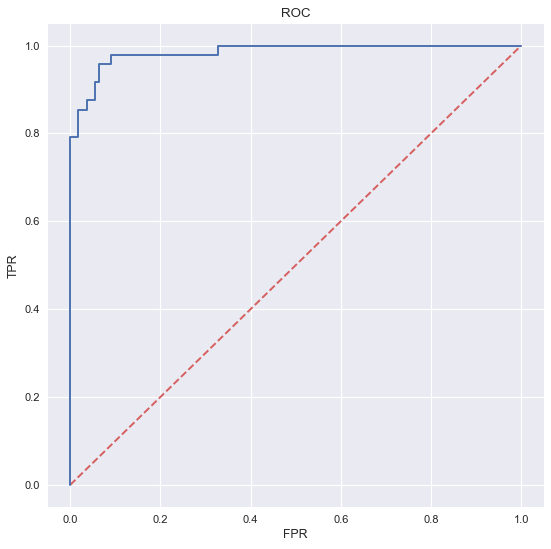

Accuracy:  0.930379746835443
Recall:  0.9583333333333334
Precision:  0.8363636363636363
F_Score:  0.8932038834951457
ROC-AUC:  0.9844696969696969


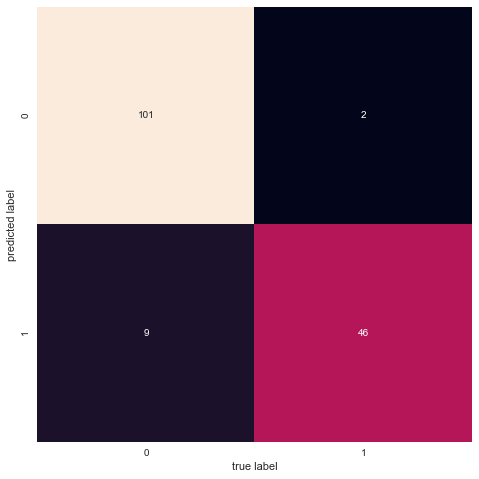

In [101]:
model = LogisticRegression(maxIter=20)
paramGrid = ParamGridBuilder().addGrid(model.regParam, [0.01,0.1,0.99]).addGrid(model.elasticNetParam, [0.001,0.5,0.99]).build()

log_reg = fit_classification(model, params=paramGrid, model_name='Logistic Regression')

#### Random Forrest

CV Average Metrics:  [0.9813941526106319, 0.9826446615657778, 0.9827246870603639, 0.9862477559144778, 0.9899258724698892, 0.9871953811026556, 0.984767009453503, 0.9877437266657005, 0.9872766364694829]
Accuracy-maximizing threshold was: 0.3694827935444313
f1-maximizing threshold was: 0.3694827935444313
recall-maximizing threshold was: 0.3694827935444313


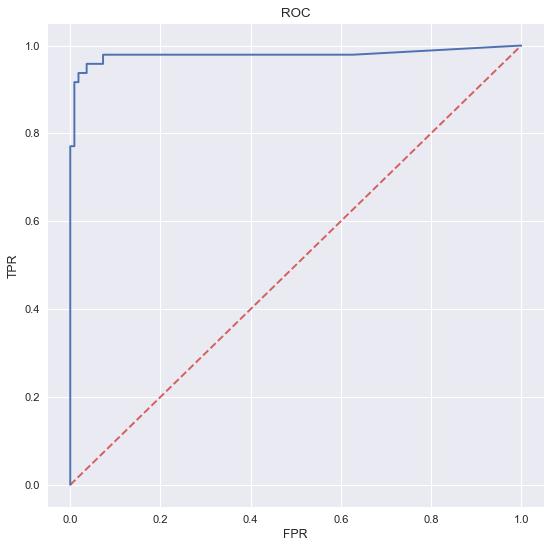

Accuracy:  0.9556962025316456
Recall:  0.9583333333333334
Precision:  0.9019607843137255
F_Score:  0.9292929292929293
ROC-AUC:  0.9790719696969696


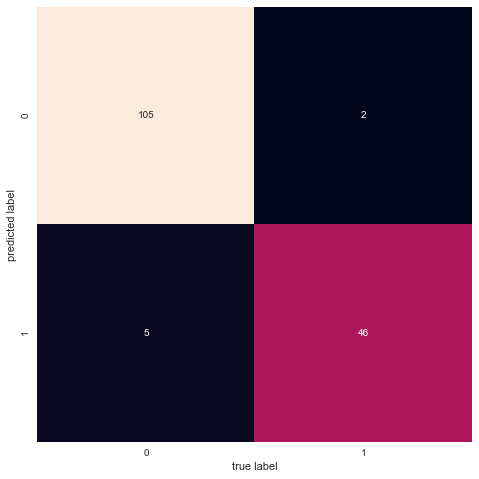

RandomForestClassificationModel (uid=RandomForestClassifier_4ec9af49bd5e2faee7f2) with 20 trees

In [102]:
model = RandomForestClassifier()
paramGrid = ParamGridBuilder().addGrid(model.maxDepth, [2, 5, 15]).addGrid(model.maxBins, [5, 30,50]).build()

fit_classification(model, params=paramGrid, model_name='Random Forest')

#### Naive Bayes

CV Average Metrics:  [0.028182091088429534, 0.028182091088429534, 0.028182091088429534, 0.028182091088429534, 0.028182091088429534, 0.028182091088429534, 0.028182091088429534, 0.028182091088429534, 0.028182091088429534]
Accuracy-maximizing threshold was: 0.9959254220255523
f1-maximizing threshold was: 0.00010687759951376535
recall-maximizing threshold was: 3.4505450881665514e-17


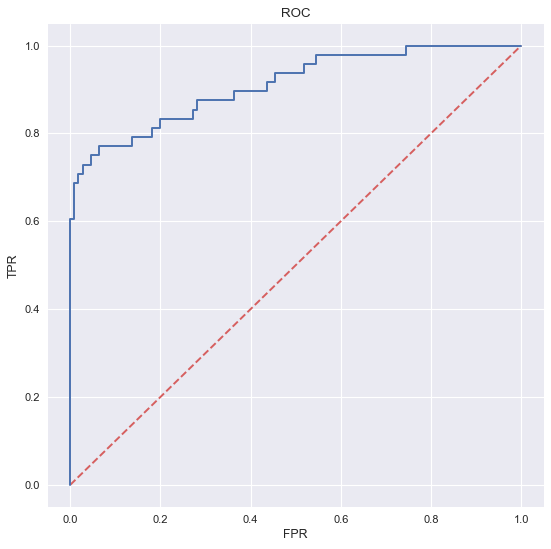

Accuracy:  0.8924050632911392
Recall:  0.6875
Precision:  0.9428571428571428
F_Score:  0.7951807228915663
ROC-AUC:  0.9098484848484849


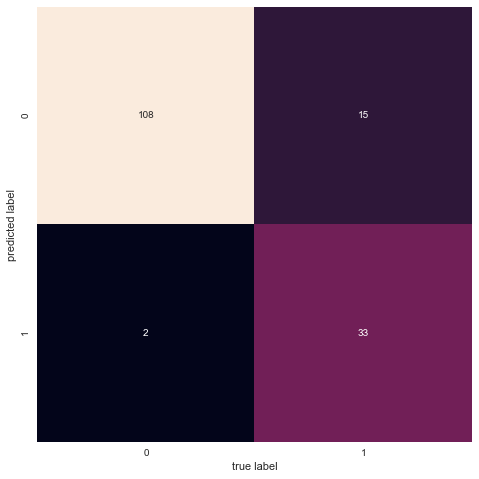

NaiveBayes_4862a138e263fdd664f6

In [103]:
model = NaiveBayes()

fit_classification(model, model_name='Naive Bayes')

CV Average Metrics:  [0.9646679591416233, 0.9045223314237041, 0.9459348754304554]
Accuracy-maximizing threshold was: 0.40889798941423233
f1-maximizing threshold was: 0.40889798941423233
recall-maximizing threshold was: 0.017622525389320146


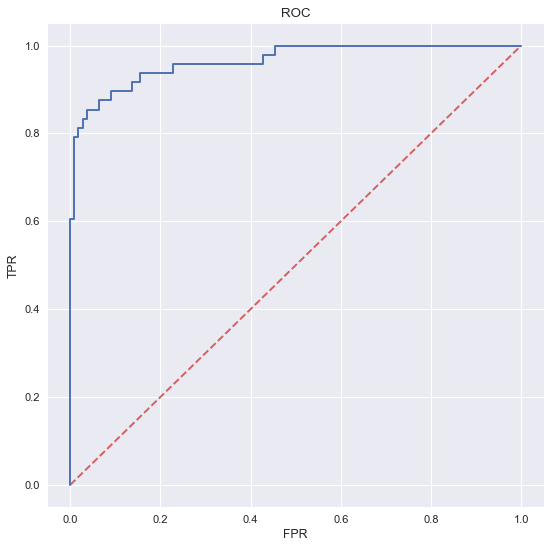

Accuracy:  0.9240506329113924
Recall:  0.7708333333333334
Precision:  0.9736842105263158
F_Score:  0.8604651162790697
ROC-AUC:  0.9642045454545454


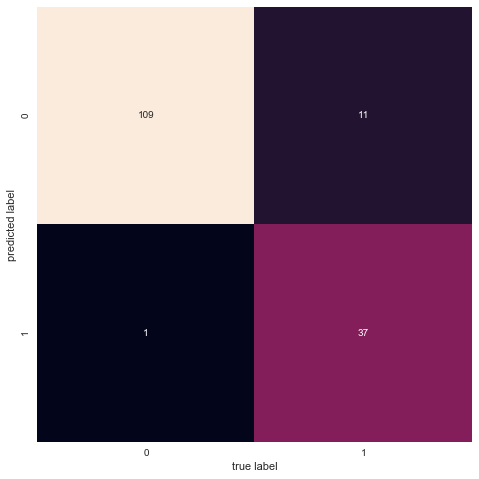

MultilayerPerceptronClassifier_4361a9abb42c60cc5ae8

In [104]:
model = MultilayerPerceptronClassifier()
layer_list = [[30,100,100,2],
              [30,10,10,2],
              [30, 10, 2]]

paramGrid = ParamGridBuilder().addGrid(model.layers, layer_list).build()

fit_classification(model, params=paramGrid, model_name='MLP')

In [105]:
model_performance = pd.DataFrame([Models,AUC,Precision,Recall,F1])
model_performance = model_performance.T
model_performance.reset_index(drop=True)
model_performance.rename(columns = {0:'Model Name',1:'AUC', 2:'Precision',3:'Recall',4:'F-1'}, inplace = True)
model_performance

Model Name       AUC Precision    Recall       F-1
0  Logistic Regression   0.98447  0.836364  0.958333  0.893204
1        Random Forest  0.979072  0.901961  0.958333  0.929293
2          Naive Bayes  0.909848  0.942857    0.6875  0.795181
3                  MLP  0.964205  0.973684  0.770833  0.860465

In [106]:
def output_tracer(metric,color) :
    tracer = go.Bar(y = model_performance["Model Name"] ,
                    x = model_performance[metric],
                    orientation = "h",name = metric ,
                    marker = dict(line = dict(width =.7),
                                  color = color)
                   )
    return tracer

layout = go.Layout(dict(title = "Model performances",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "metric",
                                     zerolinewidth=1,
                                     ticklen=5,gridwidth=2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                        margin = dict(l = 250),
                        height = 780
                       )
                  )


trace1  = output_tracer("AUC","#6699FF")
trace2  = output_tracer('Precision',"red")
trace3  = output_tracer('Recall',"#33CC99")
trace4  = output_tracer('F-1',"lightgrey")

metric_data = [trace1,trace2,trace3,trace4]
fig = go.Figure(data=metric_data,layout=layout)
py.iplot(fig)